### Modelo de regresión precios de vehiculos usados

 Crear un modelo de regresión para predecir el precio de un vehículo usado.

#### Librerias

In [30]:
import pandas as pd
import numpy as np 
import math
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Data Wrangling

In [2]:
vehicle_prices = pd.read_csv("vehicle_prices.csv")

In [3]:
vehicle_prices.head(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,make
0,Corsa,2018,7885,Manual,9876,Petrol,145.0,55.4,1.4,vauxhall
1,Corsa,2019,11995,Manual,2500,Petrol,145.0,54.3,1.4,vauxhall
2,Corsa,2017,9777,Automatic,9625,Petrol,145.0,47.9,1.4,vauxhall
3,Corsa,2016,8500,Manual,25796,Petrol,30.0,55.4,1.4,vauxhall
4,Corsa,2019,10000,Manual,3887,Petrol,145.0,43.5,1.4,vauxhall


#####  Checking null values

In [4]:
samples = vehicle_prices.shape[0]
keep_cols = []
drop_cols = []

for col in vehicle_prices.columns:
    nas = vehicle_prices[col].isna().sum()
    percent = round(100*nas/samples,2)
    if nas > 0:
        print('{0:<20} {1:<20} {2}%'.format(col,nas,percent))
    if percent < 30:
        keep_cols.append(col)
    else:
        drop_cols.append(col)

tax                  9353                 8.62%
mpg                  9353                 8.62%


Aquí podemos notar que las únicas 2 columnas que tienen valores nulos son la columna tax y mpg, al ser pocos datos nulos voy a considerar alguna de estas 2 opciones para lidiar con eso:
* Imputacion por medio de moda o mediana
* Hacerle drop a los valores

##### Cheking dataset variable types

In [5]:
num_features = vehicle_prices.select_dtypes(include='number').columns
cat_features = vehicle_prices.select_dtypes(exclude='number').columns

print('Numerical Features:')
for f in num_features:
    print(f,end=', ')

print('\n\nCategorical Features:')
for f in cat_features:
    print(f,end=', ')

Numerical Features:
year, price, mileage, tax, mpg, engineSize, 

Categorical Features:
model, transmission, fuelType, make, 

Aqui podemos ver la división de los tipos de dato que tenemos

<AxesSubplot:>

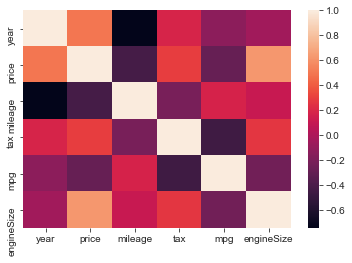

In [56]:
correlation_0 = vehicle_prices.corr()
sn.heatmap(correlation_0, xticklabels = correlation_0.columns, yticklabels=correlation_0.columns)

##### Cheking categorical values

In [6]:
vehicle_prices.transmission.value_counts()

Manual       61308
Semi-Auto    24903
Automatic    22319
Other           10
Name: transmission, dtype: int64

Podemos ver que el tipo de transmisión *other* tiene solamente 10 observaciones, por lo cual vamos a quitarla para que no haga ruido

In [7]:
vehicle_prices.fuelType.value_counts()

Petrol      59875
Diesel      45177
Hybrid       3229
Other         253
Electric        6
Name: fuelType, dtype: int64

Al igual que con el tipo de transmisión , podemos ver que el tipo de carro *eléctrico* y *other* no representan datos sifnificativos , por lo cual vamos a quitarla tambien

In [8]:
vehicle_prices.make.value_counts()

ford        23419
mercedes    17018
vw          15157
vauxhall    13632
bmw         10781
audi        10668
toyota       6738
skoda        6267
hyundai      4860
Name: make, dtype: int64

La variable **make** es donde encontramos las marcas del vehículo

In [9]:
vehicle_prices.model.unique()

array(['Corsa', 'Astra', 'Viva', 'Mokka', 'Mokka X', 'Crossland X',
       'Zafira', 'Meriva', 'Zafira Tourer', 'Adam', 'Grandland X',
       'Antara', 'Insignia', 'Ampera', 'GTC', 'Combo Life', 'Vivaro',
       'Cascada', 'Kadjar', 'Agila', 'Tigra', 'Vectra', '5 Series',
       '6 Series', '1 Series', '7 Series', '2 Series', '4 Series', 'X3',
       '3 Series', 'X5', 'X4', 'i3', 'X1', 'M4', 'X2', 'X6', '8 Series',
       'Z4', 'X7', 'M5', 'i8', 'M2', 'M3', 'M6', 'Z3', 'T-Roc', 'Golf',
       'Passat', 'T-Cross', 'Polo', 'Tiguan', 'Sharan', 'Up', 'Scirocco',
       'Beetle', 'Caddy Maxi Life', 'Caravelle', 'Touareg', 'Arteon',
       'Touran', 'Golf SV', 'Amarok', 'Tiguan Allspace', 'Shuttle',
       'Jetta', 'CC', 'California', 'Caddy Life', 'Caddy', 'Caddy Maxi',
       'Eos', 'Fox', 'I20', 'Tucson', 'I10', 'IX35', 'I30', 'I40',
       'Ioniq', 'Kona', 'Veloster', 'I800', 'IX20', 'Santa Fe', 'Accent',
       'Terracan', 'Getz', 'Amica', 'A1', 'A6', 'A4', 'A3', 'Q3', 'Q5',
       'A5'

Esta variable nos puede llegar a causar problema por la cantidad de datos diferentes que tiene

##### Checking numerical values

In [10]:
vehicle_prices.year.value_counts()

2019    29955
2017    23686
2016    16948
2018    15092
2015     8359
2020     4657
2014     4377
2013     2818
2012      702
2011      477
2010      369
2009      321
2008      233
2007      185
2006       92
2005       84
2004       55
2003       39
2002       36
2001       20
2000        9
1998        9
1999        6
1997        4
1970        2
1996        2
1995        1
2060        1
1991        1
Name: year, dtype: int64

In [11]:
years_ = vehicle_prices[vehicle_prices['year'] > 2012]  

In [12]:
years_.year.unique()

array([2018, 2019, 2017, 2016, 2013, 2014, 2015, 2020, 2060], dtype=int64)

<AxesSubplot:xlabel='year', ylabel='count'>

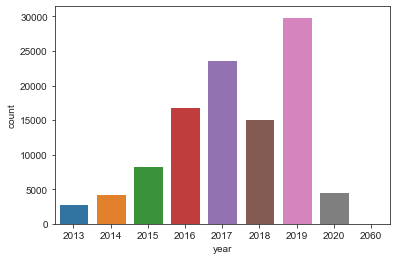

In [13]:

sn.set_style('ticks')
sn.countplot(x='year', data = years_)

Elegimos usar los datos a partir del 2012 ya que solamente estos son significativos y cuentan con más de 1,000 observaciones, así mismo podemos ver que existe 1 dato en el año 2060, por lo cual vamos a quitarlo

d:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mileage', ylabel='Density'>

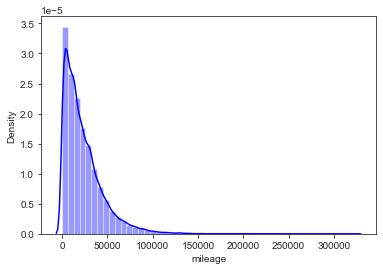

In [15]:
sn.distplot(vehicle_prices.mileage, color='blue')

Al ver esta gráfica podemos ver que la data no está distribuida de manera normal, por lo cual que normalizarla

d:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tax', ylabel='Density'>

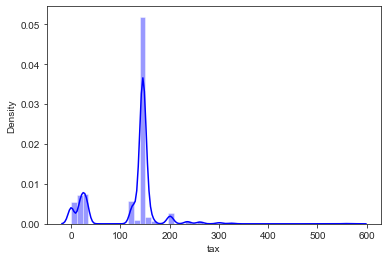

In [14]:
sn.distplot(vehicle_prices.tax,color='blue')

Hay que normalizar este dato también

d:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tax', ylabel='Density'>

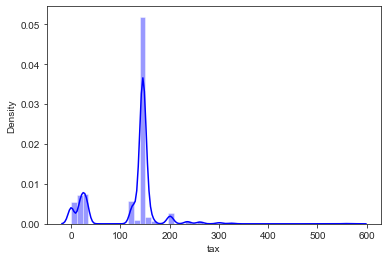

In [22]:
sn.distplot(vehicle_prices.tax ,color='blue')

Dato a normalizar

d:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mpg', ylabel='Density'>

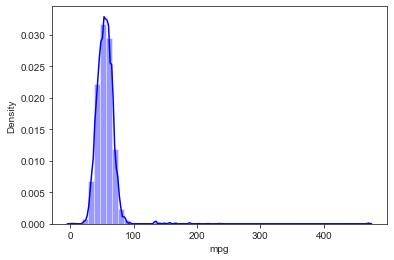

In [23]:
sn.distplot(vehicle_prices.mpg, color='blue')

d:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='engineSize', ylabel='Density'>

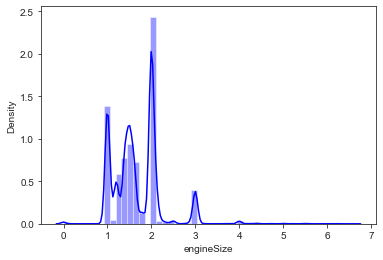

In [24]:
sn.distplot(vehicle_prices.engineSize, color='blue')

También hay que normalizar la variable

# Imputation

In [37]:
tax = vehicle_prices['tax'].mean()
tax =math.floor(tax)
mpg = vehicle_prices['mpg'].mean()
mpg = math.floor(mpg)
print("Media de tax" , tax , "y la media de media de mpg", mpg)

Media de tax 120 y la media de media de mpg 55


In [38]:
vehicle_prices['tax'].fillna(tax, inplace = True)

In [39]:
vehicle_prices['mpg'].fillna(mpg, inplace = True)

In [46]:
filtered_vehicles = vehicle_prices[vehicle_prices['year'] > 2012]  

In [50]:
filtered_vehicles['year'].unique()

array([2018, 2019, 2017, 2016, 2013, 2014, 2015, 2020, 2060], dtype=int64)

In [51]:
filtered_vehicles=filtered_vehicles[filtered_vehicles['year']!=2060]

In [52]:
filtered_vehicles['year'].unique()

array([2018, 2019, 2017, 2016, 2013, 2014, 2015, 2020], dtype=int64)

Ahora ya tenemos listos nuestros datos numéricos

#### Split de data

In [60]:
df_inicial = filtered_vehicles

In [61]:
df_inicial.head(1)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,make
0,Corsa,2018,7885,Manual,9876,Petrol,145.0,55.4,1.4,vauxhall


In [63]:
df_inicial = df_inicial.drop('price', axis = 1)
y = df_inicial[['price']].copy()

KeyError: "['price'] not found in axis"